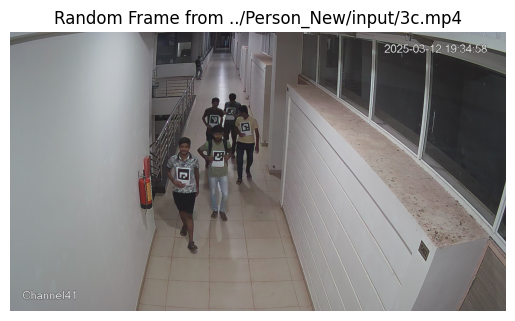

In [1]:
# Load some random frame from a video file

import cv2
import random
import os
import matplotlib.pyplot as plt

def load_random_frame(video_path):
    # Check if the video file exists
    if not os.path.isfile(video_path):
        raise FileNotFoundError(f"Video file {video_path} does not exist.")

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Generate a random frame index
    random_frame_index = 400

    # Set the video capture to the random frame index
    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)

    # Read the frame
    ret, frame = cap.read()

    # Release the video capture object
    cap.release()

    if not ret:
        raise RuntimeError(f"Failed to read frame at index {random_frame_index}.")

    return frame

video_path = "../Person_New/input/3c.mp4"  # Replace with your video file path
try:
    frame = load_random_frame(video_path)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.title(f"Random Frame from {video_path}")
    plt.show()
except Exception as e:
    print(f"Error: {e}")


0: 384x640 5 persons, 376.8ms
Speed: 4.4ms preprocess, 376.8ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)
Person 1: Box: [     604.05      405.19      736.46      859.44], Confidence: 0.91
Person 2: Box: [     724.28      358.36      863.56      732.81], Confidence: 0.89
Person 3: Box: [     867.55      279.99      968.77      590.99], Confidence: 0.88
Person 4: Box: [     742.47      251.84      829.03      434.03], Confidence: 0.78
Person 5: Box: [      823.2      233.89      896.44      486.83], Confidence: 0.69

0: 384x640 5 persons, 346.9ms
Speed: 2.0ms preprocess, 346.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Person 1 has 17 valid keypoints.
Person 2 has 17 valid keypoints.
Person 3 has 16 valid keypoints.
Person 4 has 14 valid keypoints.
Person 5 has 17 valid keypoints.


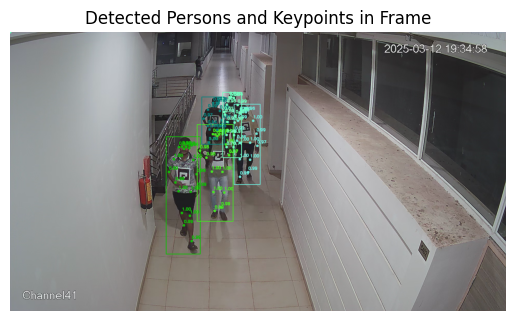

In [2]:
import numpy as np
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the YOLOv8 object detection model for persons (class 0)
model_person = YOLO("./weights/yolo11x.pt")  
# Load the YOLOv8 pose estimation model
model_pose = YOLO("./weights/yolo11x-pose.pt")  

skeleton_frame = frame.copy()
# Perform person detection on the frame
results_person = model_person(skeleton_frame, show=False, conf=0.4)  

# List to hold detected persons and their bounding boxes
detect_persons = []
for result in results_person:
    # Extract the bounding boxes, confidence scores, and class IDs
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
    confs = result.boxes.conf.cpu().numpy()  # Confidence scores
    cls = result.boxes.cls.cpu().numpy()    # Class IDs

    # Filter for persons (class ID 0)
    for box, conf, class_id in zip(boxes, confs, cls):
        if class_id == 0:  # Person class ID
            detect_persons.append((box, conf))

# Print detected persons
for i, (box, conf) in enumerate(detect_persons):
    print(f"Person {i+1}: Box: {box}, Confidence: {conf:.2f}")

# Perform pose estimation on the frame
results_pose = model_pose(skeleton_frame, show=False, conf=0.4)

# Function to calculate IoU (Intersection over Union)
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Calculate the coordinates of the intersection box
    x1_inter = max(x1, x1_p)
    y1_inter = max(y1, y1_p)
    x2_inter = min(x2, x2_p)
    y2_inter = min(y2, y2_p)

    # Calculate the area of intersection
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Calculate the areas of both boxes
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    # Calculate the IoU
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Dictionary to store keypoints for each person
person_keypoints = {}

# List of colors to differentiate each person
colors = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in range(len(detect_persons))]

# Iterate over the detected persons
for person_idx, (person_box, _) in enumerate(detect_persons):
    max_iou = 0
    matched_result = None
    
    # Check each pose detection result and match it with the person's bounding box using IoU
    for result in results_pose:
        boxes_pose = result.boxes.xyxy.cpu().numpy()  # Pose bounding boxes
        keypoints_data = result.keypoints.xy.cpu().numpy()  # Keypoints
        confs = result.keypoints.conf.cpu().numpy()  # Confidence scores

        # Iterate over detected keypoints for this result
        for i, (box, keypoints, keypoint_confidences) in enumerate(zip(boxes_pose, keypoints_data, confs)):
            # Calculate IoU between person bounding box and pose bounding box
            current_iou = iou(person_box, box)
            if current_iou > max_iou:
                max_iou = current_iou
                matched_result = (keypoints, keypoint_confidences)
    
    if matched_result:
        keypoints_data, keypoint_confs = matched_result
        valid_keypoints_count = sum(c > 0.25 for c in keypoint_confs)
        person_keypoints[person_idx] = (keypoints_data, keypoint_confs, valid_keypoints_count)

# Print the number of valid keypoints detected for each person
for person_idx, (keypoints_data, keypoint_confs, valid_keypoints_count) in person_keypoints.items():
    print(f"Person {person_idx+1} has {valid_keypoints_count} valid keypoints.")

# Display detected keypoints with colors for each person
for person_idx, (keypoints_data, keypoint_confs, _) in person_keypoints.items():
    # Random color for each person
    color = colors[person_idx]

    for kp, conf in zip(keypoints_data, keypoint_confs):
        x, y = map(int, kp)
        if conf > 0.25:  # Only draw keypoints with confidence above 0.25
            cv2.circle(skeleton_frame, (x, y), 5, color, -1)  # Draw circle for keypoint
            cv2.putText(skeleton_frame, f'{conf:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw bounding box for each person
    person_box = detect_persons[person_idx][0]
    x1, y1, x2, y2 = map(int, person_box)
    cv2.rectangle(skeleton_frame, (x1, y1), (x2, y2), color, 2)  # Draw bounding box for person

# Show the frame with detected persons and keypoints
plt.imshow(cv2.cvtColor(skeleton_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title(f"Detected Persons and Keypoints in Frame")
plt.show()


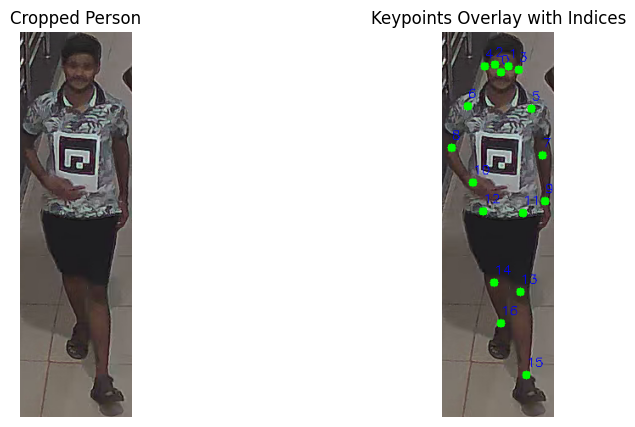

In [3]:
# Visualize one person's cropped bounding box and keypoints with indices (0-16)

import matplotlib.pyplot as plt
import cv2

# Select the first person (or any specific person by index)
person_idx = 0  # Change this index to select a different person

if person_idx in person_keypoints:
    # Get the bounding box and keypoints for the selected person
    person_box = detect_persons[person_idx][0]
    keypoints_data, keypoint_confs, _ = person_keypoints[person_idx]

    # Crop the bounding box from the original frame
    x1, y1, x2, y2 = map(int, person_box)
    cropped_person = frame[y1:y2, x1:x2]

    # Create a copy of the frame to overlay keypoints
    keypoints_frame = frame.copy()

    # Draw keypoints on the frame with indices (0-16)
    for idx, (kp, conf) in enumerate(zip(keypoints_data, keypoint_confs)):
        x, y = map(int, kp)
        if conf > 0.25:  # Only draw keypoints with confidence above 0.25
            cv2.circle(keypoints_frame, (x, y), 5, (0, 255, 0), -1)  # Green keypoints
            cv2.putText(keypoints_frame, str(idx), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    keypoints_frame = keypoints_frame[y1:y2, x1:x2]
    # Display the cropped person and keypoints side by side
    plt.figure(figsize=(10, 5))

    # Show the cropped person
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cropped_person, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Cropped Person")

    # Show the frame with keypoints
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(keypoints_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Keypoints Overlay with Indices")

    plt.show()
else:
    print(f"Person {person_idx + 1} not found in detected keypoints.")

In [4]:
# Getting specific lower body keypoints details like hip length, thigh length, shin length, and angles

import numpy as np

def get_lower_body_details(keypoints_data):
    # Define the keypoint indices for specific lower body parts
    hip_indices = [11, 12]  # Example: left and right hips
    thigh_indices = [11, 13, 12, 14]  # Example: left and right thighs
    shin_indices = [13, 15, 14, 16]  # Example: left and right shins

    # Calculate hip length (distance between left and right hips)
    x1, y1 = keypoints_data[hip_indices[0]]
    x2, y2 = keypoints_data[hip_indices[1]]
    hip_length = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    # Calculate thigh lengths (left and right)
    left_thigh_length = ((keypoints_data[thigh_indices[0]][0] - keypoints_data[thigh_indices[1]][0]) ** 2 +
                         (keypoints_data[thigh_indices[0]][1] - keypoints_data[thigh_indices[1]][1]) ** 2) ** 0.5
    right_thigh_length = ((keypoints_data[thigh_indices[2]][0] - keypoints_data[thigh_indices[3]][0]) ** 2 +
                          (keypoints_data[thigh_indices[2]][1] - keypoints_data[thigh_indices[3]][1]) ** 2) ** 0.5

    # Calculate shin lengths (left and right)
    left_shin_length = ((keypoints_data[shin_indices[0]][0] - keypoints_data[shin_indices[1]][0]) ** 2 +
                        (keypoints_data[shin_indices[0]][1] - keypoints_data[shin_indices[1]][1]) ** 2) ** 0.5
    right_shin_length = ((keypoints_data[shin_indices[2]][0] - keypoints_data[shin_indices[3]][0]) ** 2 +
                         (keypoints_data[shin_indices[2]][1] - keypoints_data[shin_indices[3]][1]) ** 2) ** 0.5

    # Calculate angles at the knees (left and right)
    def calculate_angle(a, b, c):
        # Calculate the angle between vectors AB and BC
        ab = (b[0] - a[0], b[1] - a[1])
        bc = (c[0] - b[0], c[1] - b[1])
        dot_product = ab[0] * bc[0] + ab[1] * bc[1]
        magnitude_ab = (ab[0] ** 2 + ab[1] ** 2) ** 0.5
        magnitude_bc = (bc[0] ** 2 + bc[1] ** 2) ** 0.5
        if magnitude_ab == 0 or magnitude_bc == 0:
            return 0  # Avoid division by zero
        angle = np.arccos(dot_product / (magnitude_ab * magnitude_bc))
        return np.degrees(angle)

    left_knee_angle = calculate_angle(keypoints_data[11], keypoints_data[13], keypoints_data[15])
    right_knee_angle = calculate_angle(keypoints_data[12], keypoints_data[14], keypoints_data[16])

    # Return the calculated lengths and angles as a dictionary
    return {
        "hip_length": hip_length,
        "left_thigh_length": left_thigh_length,
        "right_thigh_length": right_thigh_length,
        "left_shin_length": left_shin_length,
        "right_shin_length": right_shin_length,
        "left_knee_angle": left_knee_angle,
        "right_knee_angle": right_knee_angle
    }

# Example usage
person_details = {}
for person_idx, (keypoints_data, _, _) in person_keypoints.items():
    details = get_lower_body_details(keypoints_data)
    person_details[person_idx + 1] = details
    print(f"Person {person_idx+1}:")
    print(f"  Hip Length: {details['hip_length']:.2f}")
    print(f"  Left Thigh Length: {details['left_thigh_length']:.2f}")
    print(f"  Right Thigh Length: {details['right_thigh_length']:.2f}")
    print(f"  Left Shin Length: {details['left_shin_length']:.2f}")
    print(f"  Right Shin Length: {details['right_shin_length']:.2f}")
    print(f"  Left Knee Angle: {details['left_knee_angle']:.2f}°")
    print(f"  Right Knee Angle: {details['right_knee_angle']:.2f}°")

Person 1:
  Hip Length: 46.92
  Left Thigh Length: 93.29
  Right Thigh Length: 84.83
  Left Shin Length: 97.60
  Right Shin Length: 48.64
  Left Knee Angle: 5.40°
  Right Knee Angle: 1.23°
Person 2:
  Hip Length: 40.92
  Left Thigh Length: 79.95
  Right Thigh Length: 79.55
  Left Shin Length: 59.09
  Right Shin Length: 73.08
  Left Knee Angle: 17.26°
  Right Knee Angle: 0.19°
Person 3:
  Hip Length: 39.05
  Left Thigh Length: 65.97
  Right Thigh Length: 63.38
  Left Shin Length: 48.51
  Right Shin Length: 67.54
  Left Knee Angle: 9.76°
  Right Knee Angle: 0.58°
Person 4:
  Hip Length: 30.68
  Left Thigh Length: 887.37
  Right Thigh Length: 50.66
  Left Shin Length: 0.00
  Right Shin Length: 880.53
  Left Knee Angle: 0.00°
  Right Knee Angle: 116.25°
Person 5:
  Hip Length: 27.98
  Left Thigh Length: 48.76
  Right Thigh Length: 49.79
  Left Shin Length: 46.58
  Right Shin Length: 47.11
  Left Knee Angle: 0.24°
  Right Knee Angle: 3.68°


In [5]:
# Getting specific upper body keypoints details like shoulder length, upper arm length, forearm length, and angles

import numpy as np

def get_upper_body_details(keypoints_data):
    # Define the keypoint indices for specific upper body parts
    shoulder_indices = [5, 6]  # Example: left and right shoulders
    upper_arm_indices = [5, 7, 6, 8]  # Example: left and right upper arms
    forearm_indices = [7, 9, 8, 10]  # Example: left and right forearms

    # Calculate shoulder length (distance between left and right shoulders)
    x1, y1 = keypoints_data[shoulder_indices[0]]
    x2, y2 = keypoints_data[shoulder_indices[1]]
    shoulder_length = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    # Calculate upper arm lengths (left and right)
    left_upper_arm_length = ((keypoints_data[upper_arm_indices[0]][0] - keypoints_data[upper_arm_indices[1]][0]) ** 2 +
                             (keypoints_data[upper_arm_indices[0]][1] - keypoints_data[upper_arm_indices[1]][1]) ** 2) ** 0.5
    right_upper_arm_length = ((keypoints_data[upper_arm_indices[2]][0] - keypoints_data[upper_arm_indices[3]][0]) ** 2 +
                              (keypoints_data[upper_arm_indices[2]][1] - keypoints_data[upper_arm_indices[3]][1]) ** 2) ** 0.5

    # Calculate forearm lengths (left and right)
    left_forearm_length = ((keypoints_data[forearm_indices[0]][0] - keypoints_data[forearm_indices[1]][0]) ** 2 +
                           (keypoints_data[forearm_indices[0]][1] - keypoints_data[forearm_indices[1]][1]) ** 2) ** 0.5
    right_forearm_length = ((keypoints_data[forearm_indices[2]][0] - keypoints_data[forearm_indices[3]][0]) ** 2 +
                            (keypoints_data[forearm_indices[2]][1] - keypoints_data[forearm_indices[3]][1]) ** 2) ** 0.5

    # Calculate angles at the elbows (left and right)
    def calculate_angle(a, b, c):
        # Calculate the angle between vectors AB and BC
        ab = (b[0] - a[0], b[1] - a[1])
        bc = (c[0] - b[0], c[1] - b[1])
        dot_product = ab[0] * bc[0] + ab[1] * bc[1]
        magnitude_ab = (ab[0] ** 2 + ab[1] ** 2) ** 0.5
        magnitude_bc = (bc[0] ** 2 + bc[1] ** 2) ** 0.5
        if magnitude_ab == 0 or magnitude_bc == 0:
            return 0  # Avoid division by zero
        angle = np.arccos(dot_product / (magnitude_ab * magnitude_bc))
        return np.degrees(angle)

    left_elbow_angle = calculate_angle(keypoints_data[5], keypoints_data[7], keypoints_data[9])
    right_elbow_angle = calculate_angle(keypoints_data[6], keypoints_data[8], keypoints_data[10])


    # Return the calculated lengths and angles as a dictionary
    return {
        "shoulder_length": shoulder_length,
        "left_upper_arm_length": left_upper_arm_length,
        "right_upper_arm_length": right_upper_arm_length,
        "left_forearm_length": left_forearm_length,
        "right_forearm_length": right_forearm_length,
        "left_elbow_angle": left_elbow_angle,
        "right_elbow_angle": right_elbow_angle
    }

# Example usage
person_details = {}
for person_idx, (keypoints_data, _, _) in person_keypoints.items():
    details = get_upper_body_details(keypoints_data)
    person_details[person_idx + 1] = details
    print(f"Person {person_idx+1}:")
    print(f"  Shoulder Length: {details['shoulder_length']:.2f}")
    print(f"  Left Upper Arm Length: {details['left_upper_arm_length']:.2f}")
    print(f"  Right Upper Arm Length: {details['right_upper_arm_length']:.2f}")
    print(f"  Left Forearm Length: {details['left_forearm_length']:.2f}")
    print(f"  Right Forearm Length: {details['right_forearm_length']:.2f}")
    print(f"  Left Elbow Angle: {details['left_elbow_angle']:.2f}°")
    print(f"  Right Elbow Angle: {details['right_elbow_angle']:.2f}°")

Person 1:
  Shoulder Length: 75.36
  Left Upper Arm Length: 56.51
  Right Upper Arm Length: 51.70
  Left Forearm Length: 54.61
  Right Forearm Length: 48.17
  Left Elbow Angle: 10.52°
  Right Elbow Angle: 52.89°
Person 2:
  Shoulder Length: 64.85
  Left Upper Arm Length: 44.55
  Right Upper Arm Length: 47.57
  Left Forearm Length: 2.66
  Right Forearm Length: 37.13
  Left Elbow Angle: 169.50°
  Right Elbow Angle: 90.02°
Person 3:
  Shoulder Length: 58.49
  Left Upper Arm Length: 51.34
  Right Upper Arm Length: 45.01
  Left Forearm Length: 47.29
  Right Forearm Length: 33.87
  Left Elbow Angle: 11.74°
  Right Elbow Angle: 27.65°
Person 4:
  Shoulder Length: 46.17
  Left Upper Arm Length: 36.13
  Right Upper Arm Length: 38.34
  Left Forearm Length: 24.22
  Right Forearm Length: 32.99
  Left Elbow Angle: 23.95°
  Right Elbow Angle: 56.12°
Person 5:
  Shoulder Length: 41.50
  Left Upper Arm Length: 33.11
  Right Upper Arm Length: 29.49
  Left Forearm Length: 17.76
  Right Forearm Length: 1

In [6]:
def get_body_relationships(keypoints_data):
    # Define keypoint indices
    shoulder_indices = [5, 6]  # Left and right shoulders
    hip_indices = [11, 12]     # Left and right hips
    thigh_indices = [11, 13, 12, 14]  # Left and right thighs
    shin_indices = [13, 15, 14, 16]   # Left and right shins
    upper_arm_indices = [5, 7, 6, 8]  # Left and right upper arms
    forearm_indices = [7, 9, 8, 10]   # Left and right forearms

    # Calculate midpoints
    def midpoint(p1, p2):
        return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

    shoulder_midpoint = midpoint(keypoints_data[shoulder_indices[0]], keypoints_data[shoulder_indices[1]])
    hip_midpoint = midpoint(keypoints_data[hip_indices[0]], keypoints_data[hip_indices[1]])

    # Torso length (distance between shoulder midpoint and hip midpoint)
    torso_length = ((shoulder_midpoint[0] - hip_midpoint[0]) ** 2 +
                    (shoulder_midpoint[1] - hip_midpoint[1]) ** 2) ** 0.5

    # Average leg length (thigh + shin)
    left_leg_length = ((keypoints_data[thigh_indices[0]][0] - keypoints_data[thigh_indices[1]][0]) ** 2 +
                       (keypoints_data[thigh_indices[0]][1] - keypoints_data[thigh_indices[1]][1]) ** 2) ** 0.5 + \
                      ((keypoints_data[shin_indices[0]][0] - keypoints_data[shin_indices[1]][0]) ** 2 +
                       (keypoints_data[shin_indices[0]][1] - keypoints_data[shin_indices[1]][1]) ** 2) ** 0.5

    right_leg_length = ((keypoints_data[thigh_indices[2]][0] - keypoints_data[thigh_indices[3]][0]) ** 2 +
                        (keypoints_data[thigh_indices[2]][1] - keypoints_data[thigh_indices[3]][1]) ** 2) ** 0.5 + \
                       ((keypoints_data[shin_indices[2]][0] - keypoints_data[shin_indices[3]][0]) ** 2 +
                        (keypoints_data[shin_indices[2]][1] - keypoints_data[shin_indices[3]][1]) ** 2) ** 0.5

    avg_leg_length = (left_leg_length + right_leg_length) / 2

    # Average arm length (upper arm + forearm)
    left_arm_length = ((keypoints_data[upper_arm_indices[0]][0] - keypoints_data[upper_arm_indices[1]][0]) ** 2 +
                       (keypoints_data[upper_arm_indices[0]][1] - keypoints_data[upper_arm_indices[1]][1]) ** 2) ** 0.5 + \
                      ((keypoints_data[forearm_indices[0]][0] - keypoints_data[forearm_indices[1]][0]) ** 2 +
                       (keypoints_data[forearm_indices[0]][1] - keypoints_data[forearm_indices[1]][1]) ** 2) ** 0.5

    right_arm_length = ((keypoints_data[upper_arm_indices[2]][0] - keypoints_data[upper_arm_indices[3]][0]) ** 2 +
                        (keypoints_data[upper_arm_indices[2]][1] - keypoints_data[upper_arm_indices[3]][1]) ** 2) ** 0.5 + \
                       ((keypoints_data[forearm_indices[2]][0] - keypoints_data[forearm_indices[3]][0]) ** 2 +
                        (keypoints_data[forearm_indices[2]][1] - keypoints_data[forearm_indices[3]][1]) ** 2) ** 0.5

    avg_arm_length = (left_arm_length + right_arm_length) / 2

    # Ratios
    leg_to_torso_ratio = avg_leg_length / torso_length if torso_length > 0 else 0
    arm_to_leg_ratio = avg_arm_length / avg_leg_length if avg_leg_length > 0 else 0

    # Symmetry checks
    arm_symmetry = abs(left_arm_length - right_arm_length)
    leg_symmetry = abs(left_leg_length - right_leg_length)

    # Return relationships as a dictionary
    return {
        "torso_length": torso_length,
        "avg_leg_length": avg_leg_length,
        "avg_arm_length": avg_arm_length,
        "leg_to_torso_ratio": leg_to_torso_ratio,
        "arm_to_leg_ratio": arm_to_leg_ratio,
        "arm_symmetry": arm_symmetry,
        "leg_symmetry": leg_symmetry
    }

# Example usage
for person_idx, (keypoints_data, _, _) in person_keypoints.items():
    relationships = get_body_relationships(keypoints_data)
    print(f"Person {person_idx + 1}:")
    print(f"  Torso Length: {relationships['torso_length']:.2f}")
    print(f"  Average Leg Length: {relationships['avg_leg_length']:.2f}")
    print(f"  Average Arm Length: {relationships['avg_arm_length']:.2f}")
    print(f"  Leg-to-Torso Ratio: {relationships['leg_to_torso_ratio']:.2f}")
    print(f"  Arm-to-Leg Ratio: {relationships['arm_to_leg_ratio']:.2f}")
    print(f"  Arm Symmetry: {relationships['arm_symmetry']:.2f}")
    print(f"  Leg Symmetry: {relationships['leg_symmetry']:.2f}")

Person 1:
  Torso Length: 123.49
  Average Leg Length: 162.18
  Average Arm Length: 105.50
  Leg-to-Torso Ratio: 1.31
  Arm-to-Leg Ratio: 0.65
  Arm Symmetry: 11.25
  Leg Symmetry: 57.42
Person 2:
  Torso Length: 109.65
  Average Leg Length: 145.83
  Average Arm Length: 65.95
  Leg-to-Torso Ratio: 1.33
  Arm-to-Leg Ratio: 0.45
  Arm Symmetry: 37.49
  Leg Symmetry: 13.59
Person 3:
  Torso Length: 85.56
  Average Leg Length: 122.70
  Average Arm Length: 88.76
  Leg-to-Torso Ratio: 1.43
  Arm-to-Leg Ratio: 0.72
  Arm Symmetry: 19.74
  Leg Symmetry: 16.44
Person 4:
  Torso Length: 74.69
  Average Leg Length: 909.28
  Average Arm Length: 65.84
  Leg-to-Torso Ratio: 12.17
  Arm-to-Leg Ratio: 0.07
  Arm Symmetry: 10.99
  Leg Symmetry: 43.82
Person 5:
  Torso Length: 67.78
  Average Leg Length: 96.12
  Average Arm Length: 45.38
  Leg-to-Torso Ratio: 1.42
  Arm-to-Leg Ratio: 0.47
  Arm Symmetry: 10.97
  Leg Symmetry: 1.55


In [17]:
# Add the VideoPose3D directory to the Python path
import sys
import os

# Update the path to the VideoPose3D directory
videopose3d_path = os.path.abspath("../Person_New/VideoPose3D")
if videopose3d_path not in sys.path:
    sys.path.append(videopose3d_path)

# Import necessary modules
import numpy as np
import torch
from common.model import TemporalModel
from common.camera import normalize_screen_coordinates

# Load the trained VideoPose3D model
checkpoint_path = "./checkpoints/pretrained_h36m_cpn.bin"  # Update with your checkpoint path
model = TemporalModel(
    num_joints_in=17,  # Number of input joints (COCO format)
    in_features=2,     # 2D keypoints (x, y)
    num_joints_out=17, # Number of output joints
    filter_widths=[3, 3, 3, 3, 3],  # Temporal convolution filter widths
    causal=False,
    dropout=0.25,
    channels=1024
)

# Load model weights
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Inspect the checkpoint keys
print("Checkpoint keys:", checkpoint.keys())

# Extract the correct state_dict from the checkpoint
if 'model_pos' in checkpoint:
    model.load_state_dict(checkpoint['model_pos'])
else:
    raise KeyError("The checkpoint does not contain the expected 'model_pos' key.")

model.eval()

# Prepare 2D keypoints for input
keypoints_2d = []
for person_idx, (keypoints_data, _, _) in person_keypoints.items():
    keypoints_2d.append(keypoints_data[:, :2])  # Extract x, y coordinates

keypoints_2d = np.array(keypoints_2d)  # Shape: (num_persons, num_joints, 2)

# Debug: Print the shape of keypoints_2d
print("Shape of keypoints_2d:", keypoints_2d.shape)

# Process each person individually
for person_idx in range(keypoints_2d.shape[0]):
    person_keypoints_2d = keypoints_2d[person_idx]  # Shape: (num_joints, 2)

    # Add batch and sequence dimensions
    # Replicate the single frame to have enough frames for the largest receptive field
    person_keypoints_2d = person_keypoints_2d[np.newaxis, np.newaxis, :, :]  # Shape: (1, 1, num_joints, 2)
    person_keypoints_2d = normalize_screen_coordinates(person_keypoints_2d, w=1000, h=1000)
    person_keypoints_2d = np.tile(person_keypoints_2d, (1, 243, 1, 1))  # Use 243 frames (> 33)

    # Convert to PyTorch tensor
    keypoints_2d_tensor = torch.from_numpy(person_keypoints_2d).float()
    # Debug: Print the shape of the tensor
    print(f"Shape of keypoints_2d_tensor for person {person_idx + 1}:", keypoints_2d_tensor.shape)

    # Perform 3D pose estimation
    with torch.no_grad():
        keypoints_3d = model(keypoints_2d_tensor)  # Shape: (1, 1, num_joints, 3)

    # Visualize or process the 3D keypoints
    print(f"3D Keypoints for person {person_idx + 1}:", keypoints_3d[0, 0])

Checkpoint keys: dict_keys(['epoch', 'lr', 'model_pos'])
Shape of keypoints_2d: (5, 17, 2)
Shape of keypoints_2d_tensor for person 1: torch.Size([1, 243, 17, 2])
3D Keypoints for person 1: tensor([[ 8.3117e-07,  3.4296e-05,  1.0075e-04],
        [-4.5789e-03,  3.9756e-02, -6.6418e-03],
        [ 5.9584e-02, -8.7245e-03,  3.4301e-01],
        [ 2.1825e-01,  1.0338e-01,  7.5048e-01],
        [ 4.5667e-03, -3.9750e-02,  6.6754e-03],
        [ 1.3137e-01,  2.0010e-01,  2.1505e-01],
        [-1.3819e-01,  2.2211e-01,  5.2281e-01],
        [ 2.2355e-02,  2.8518e-01, -2.8105e-01],
        [-6.6908e-02,  5.6664e-01, -5.4521e-01],
        [ 9.6422e-02,  4.3328e-01, -6.7756e-01],
        [-1.3141e-01,  4.7313e-01, -6.9822e-01],
        [-1.1513e-02,  4.5071e-01, -4.8142e-01],
        [-5.3513e-02,  5.5698e-01, -4.6283e-01],
        [ 7.5182e-02,  7.8466e-01, -4.4505e-01],
        [-8.3250e-02,  7.8426e-01, -5.1876e-01],
        [ 1.5687e-02,  1.0430e+00, -5.5819e-01],
        [-1.5158e-01,  7.28

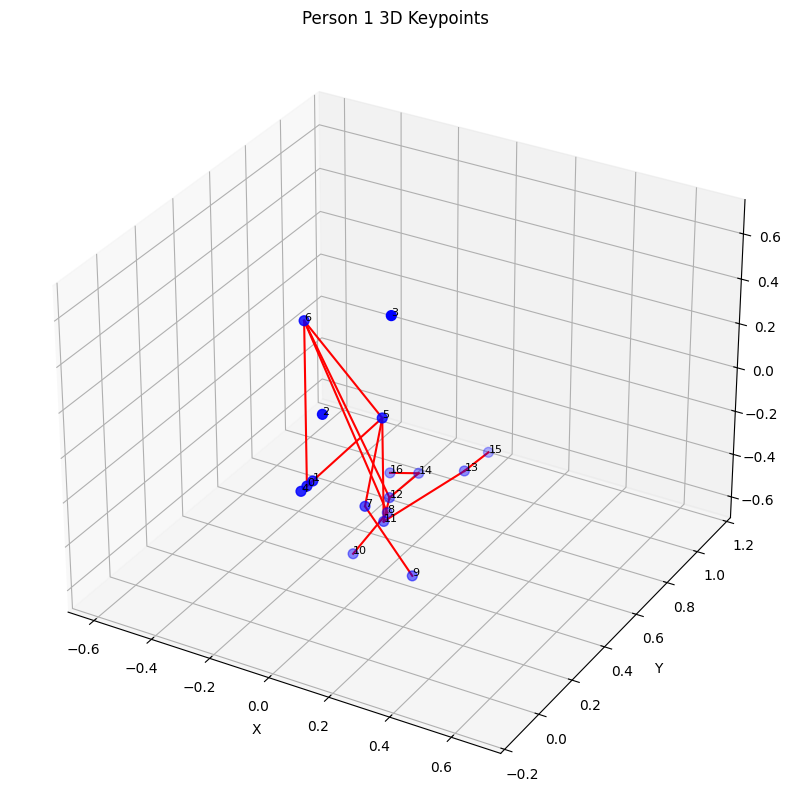

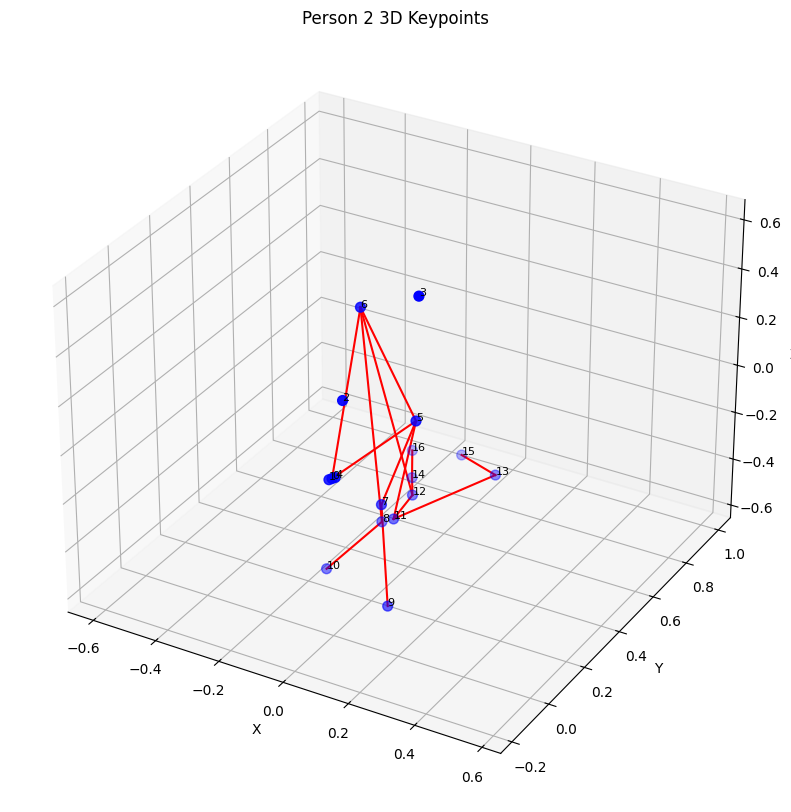

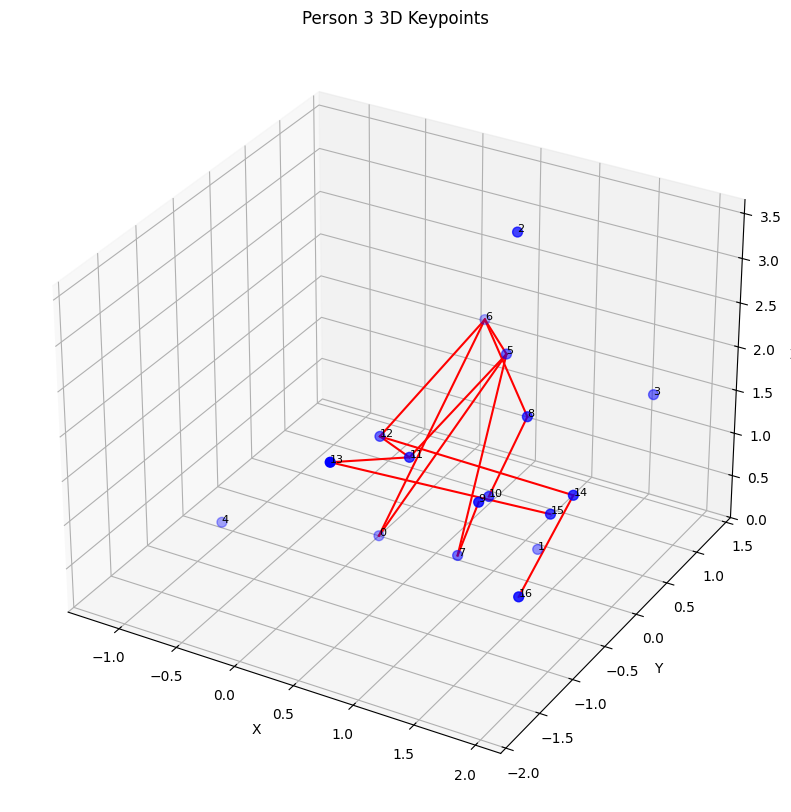

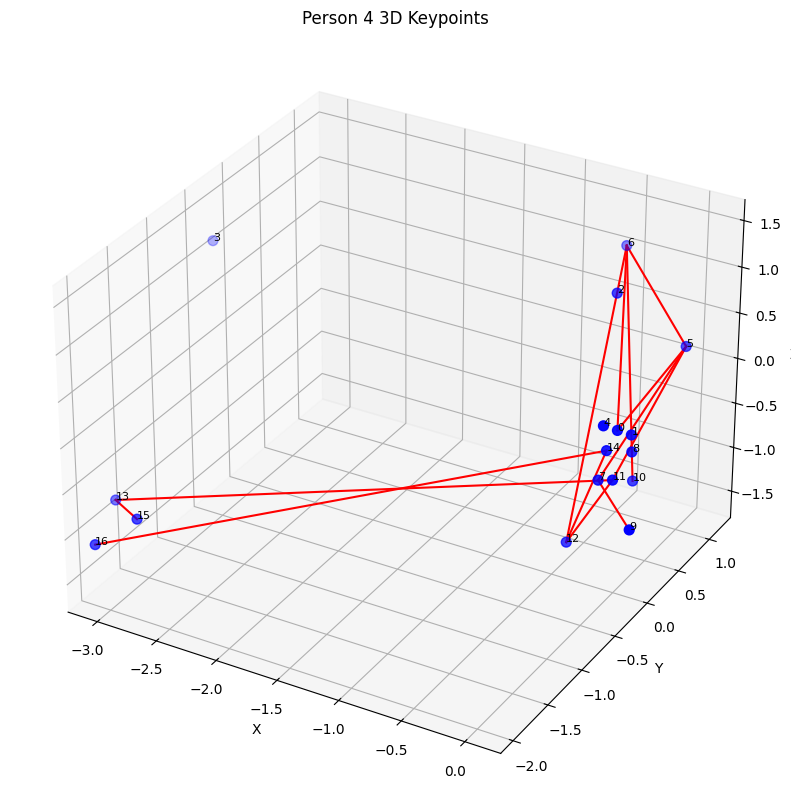

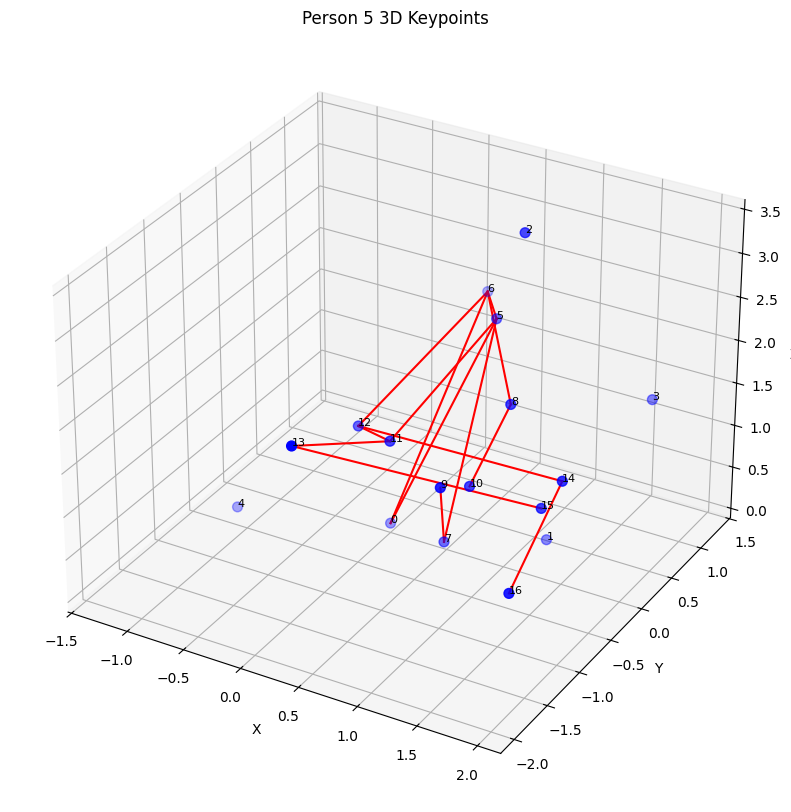

In [19]:
# Visualize the 3D keypoints
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_keypoints(keypoints_3d, title="3D Keypoints"):
    """
    Plot 3D keypoints with skeleton connections
    
    Args:
        keypoints_3d: numpy array of shape (num_joints, 3)
        title: plot title
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract x, y, z coordinates
    x = keypoints_3d[:, 0]
    y = keypoints_3d[:, 1]
    z = keypoints_3d[:, 2]
    
    # Plot keypoints
    ax.scatter(x, y, z, c='blue', marker='o', s=50)
    
    # Define skeletal connections for COCO format keypoints
    skeleton_edges = [
        # Torso
        (5, 6), (5, 11), (6, 12), (11, 12),
        # Left arm
        (5, 7), (7, 9),
        # Right arm
        (6, 8), (8, 10),
        # Left leg
        (11, 13), (13, 15),
        # Right leg
        (12, 14), (14, 16),
        # Face (connecting nose with shoulders)
        (0, 5), (0, 6)
    ]
    
    # Plot skeleton connections
    for i, j in skeleton_edges:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], color='red')
    
    # Label the points
    for i, (x_i, y_i, z_i) in enumerate(zip(x, y, z)):
        ax.text(x_i, y_i, z_i, f"{i}", fontsize=8)
    
    # Set equal aspect ratio
    max_range = np.max(np.array([np.max(x) - np.min(x), 
                                 np.max(y) - np.min(y), 
                                 np.max(z) - np.min(z)]))
    mid_x = (np.max(x) + np.min(x)) * 0.5
    mid_y = (np.max(y) + np.min(y)) * 0.5
    mid_z = (np.max(z) + np.min(z)) * 0.5
    
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(title)
    plt.show()

# For each person, plot their 3D keypoints
for person_idx in range(keypoints_2d.shape[0]):
    # Get the 3D keypoints
    person_keypoints_2d = keypoints_2d[person_idx]  # Shape: (num_joints, 2)
    person_keypoints_2d = person_keypoints_2d[np.newaxis, np.newaxis, :, :]
    person_keypoints_2d = normalize_screen_coordinates(person_keypoints_2d, w=1000, h=1000)
    person_keypoints_2d = np.tile(person_keypoints_2d, (1, 243, 1, 1))
    keypoints_2d_tensor = torch.from_numpy(person_keypoints_2d).float()
    
    # Perform 3D pose estimation
    with torch.no_grad():
        keypoints_3d = model(keypoints_2d_tensor)  # Shape: (1, 243, num_joints, 3)
    
    # Get the middle frame (to avoid edge effects)
    mid_frame = keypoints_3d[0, 0].cpu().numpy()
    
    # Plot the 3D keypoints
    plot_3d_keypoints(mid_frame, title=f"Person {person_idx + 1} 3D Keypoints")